In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, pacf

from scipy import signal
from scipy import stats

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from math import sqrt


from bike_and_station_info import *
from time_series_model import *


## Load data, add features, subset, and define proposed locations

In [2]:
#load the data
data, weather = load_data()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [3]:
#add features to the dataset
data = feature_addition(data)

In [4]:
#subset the dataframe for desired city
city = model_city(data,1)

In [5]:
int(city[city.start_time == city.start_time.min()].month)

6

In [637]:
city.date.max()

datetime.date(2019, 3, 1)

In [644]:
dates_df = city.date.value_counts().reset_index()

In [645]:
dates_df.index = pd.to_datetime(dates_df.index)

In [649]:
dates_df = dates_df.sort_values(by="index")

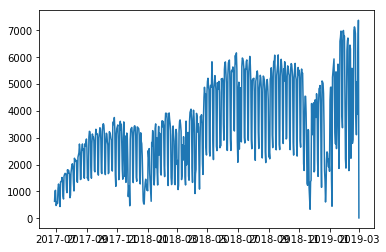

In [650]:
plt.plot(dates_df.iloc[:,0], dates_df.iloc[:,1])

In [6]:
def subset_df(df, year, month, hist=3):
    '''
    INPUT df, month and year you wish to assess
    OUTPUT subsetted historical df, current month's df, next month's df
    '''

    #remove trips where start station is the same as end station
    df = df[df.start_station_id != df.end_station_id]

    #current month df
    cdf = df[(df.year == year) & (df.month == month)]
    #next month df
    ndf = df[(df.year == year) & (df.month == (month+1))]

    excess = (month+3)-12
    if excess >0:
        uyear = year+1
        umonth = excess
        ndfu = df[(df.year == uyear)&(df.month <=umonth)]
        ndfl = df[(df.year == year)&(df.month >=month)]
        ntmdf = ndfu.append(ndfl)
    else:
        ntmdf = df[(df.year == year) & (df.month >= month+1)& (df.month <= month+3)] 
    # create a new dataframe
    # which includes the current month's data
    # as well as X months of history
    
    rollover = month-hist
    if rollover <0:
        lyear = year-1
        lmonth = 12+(rollover)+1
        dfu= df[(df.year == year)&(df.month <=month)]
        dfl= df[(df.year == lyear)&(df.month >=lmonth)]
        sub = dfu.append(dfl)
    else:
        sub = df[(df.year == year)&(df.month <=month) & (df.month>month-hist)]


    
    #create a days column
    #this will be used to forecast as well as plotting
    sub['days'] = 1
    sub['days'] = pd.to_datetime(sub['days'])
    sub['days'] = (sub.date) - sub.date.min()
    sub['days'] = sub['days'].dt.days

    return sub, cdf, ndf, ntmdf

In [7]:
sub, cdf, ndf, ntmdf= subset_df(city, 2018, 7)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [8]:
#unique months of the subsetted dataset
sub.month.unique()

array([5, 6, 7])

In [9]:
sub

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,bike_share_for_all_trip,day_of_week,date,year,month,day,hour,malfunction,age,days
312903,81034,2018-04-30 17:46:04.9970,2018-05-01 16:16:39.247,122.0,19th St at Mission St,37.760299,-122.418892,42.0,San Francisco City Hall (Polk St at Grove St),37.778650,...,No,1,2018-05-01,2018,5,1,16,False,NaN,0
312904,86142,2018-04-30 16:07:13.9190,2018-05-01 16:02:56.717,41.0,Golden Gate Ave at Polk St,37.781270,-122.418740,67.0,San Francisco Caltrain Station 2 (Townsend St...,37.776639,...,Yes,1,2018-05-01,2018,5,1,16,False,45.0,0
312905,68839,2018-04-30 17:11:57.4640,2018-05-01 12:19:16.787,284.0,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,115.0,Jackson Playground,37.765026,...,No,1,2018-05-01,2018,5,1,12,False,45.0,0
312907,68093,2018-04-30 15:39:18.3530,2018-05-01 10:34:12.246,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,30.0,San Francisco Caltrain (Townsend St at 4th St),37.776598,...,No,1,2018-05-01,2018,5,1,10,False,58.0,0
312908,34933,2018-04-30 23:26:14.6610,2018-05-01 09:08:28.561,71.0,Broderick St at Oak St,37.773063,-122.439078,95.0,Sanchez St at 15th St,37.766219,...,No,1,2018-05-01,2018,5,1,9,False,NaN,0
312913,323,2018-04-30 23:56:57.0450,2018-05-01 00:02:20.084,36.0,Folsom St at 3rd St,37.783830,-122.398870,62.0,Victoria Manalo Draves Park,37.777791,...,No,1,2018-05-01,2018,5,1,0,False,34.0,0
312914,275,2018-04-30 23:56:46.0220,2018-05-01 00:01:21.044,114.0,Rhode Island St at 17th St,37.764478,-122.402570,64.0,5th St at Brannan St,37.776754,...,No,1,2018-05-01,2018,5,1,0,False,33.0,0
444071,56791,2018-05-31 21:41:51.4750,2018-06-01 13:28:22.722,44.0,Civic Center/UN Plaza BART Station (Market St ...,37.781074,-122.411738,78.0,Folsom St at 9th St,37.773717,...,No,4,2018-06-01,2018,6,1,13,False,NaN,31
444073,43204,2018-05-31 21:09:48.0150,2018-06-01 09:09:52.485,17.0,Embarcadero BART Station (Beale St at Market St),37.792251,-122.397086,93.0,4th St at Mission Bay Blvd S,37.770407,...,No,4,2018-06-01,2018,6,1,9,False,NaN,31
444074,67102,2018-05-31 14:09:54.9720,2018-06-01 08:48:17.815,106.0,Sanchez St at 17th St,37.763242,-122.430675,47.0,4th St at Harrison St,37.780955,...,No,4,2018-06-01,2018,6,1,8,False,40.0,31


In [10]:
type(sub.days.iloc[0])

numpy.int64

In [11]:
#proposed stations
ps = new_stn_coords(cdf, ndf)
ps

[363.0, 364.0, 365.0, 367.0]

In [210]:
import statsmodels.api as sm
def create_monthly_dummies(series):
    month = series.index.month
    # Only take 11 of the 12 dummies to avoid strict collinearity.
    return pd.get_dummies(month).iloc[:, :11]
def fit_seasonal_trend(series):
    dummies = create_monthly_dummies(series)
    X = sm.add_constant(dummies.values)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)
baseball_seasonal_trend = fit_seasonal_trend(baseball_series)
baseball_seasonal_detrended = baseball_series - baseball_seasonal_trend

## Identify neighbor stations

In [12]:
def knn_proposed_stn(sub, df1, df2, proposed_stn, num_neighbors = 3):
    '''
    INPUT 3 dataframes, subsetted df, current month's df, and next month's df
            as well as the number of desired neighbors
    OUTPUT dict of knn, dict for id and coordinate combinations for each current and next month


    '''

    #all coordinates for each trip
    coordinates = np.array(df1[['start_station_longitude', 'start_station_latitude']])
    
    #unique coords in df1
    unique_coords = np.unique(coordinates, axis = 0)
    
    #current month
    cm = df1.month.unique()[0]
    
    #get the id and coords for current month
    id_coord_df1 = stn_coords(df1)
    id_coord_df2 = stn_coords(df2)
    
    knn_dict = {}
    
    #iterate through each proposed station
    for p in proposed_stn:
        
        #use euclidean_distance to find distances between each point
        dist = euclidean_distance(id_coord_df2.get(p), unique_coords)
        
        #sort the distances from closest to furthest
        potential_neighbors = unique_coords[np.argsort(dist)]
        
        neighbors = np.array([0,0])
        
        #in the list of potential neighbors, use neighbors with more than 30 days of trips
        for pot in potential_neighbors:
            
            #get the station id
            sid = sub.start_station_id[(sub.start_station_longitude==pot[0])\
                                       &(sub.start_station_latitude==pot[1])].unique()[0]
#             if len(cdf.days[cdf.start_station_id==sid].unique())>10:
            if len(sub.days[(sub.start_station_id==sid) \
                            & (sub.month == cm)].unique())>10:
                neighbors = np.vstack((neighbors, pot))
        neighbors = neighbors[1:num_neighbors+1]
        
        #list for storing neighboring station ids
        neighbor_ids = []
        for i in range(num_neighbors):
            knn_id = sub.start_station_id[(sub.start_station_longitude == neighbors[i][0]) &(sub.start_station_latitude == neighbors[i][1])].iloc[0]
            neighbor_ids.append(int(knn_id))
        knn_dict[int(p)] = neighbor_ids
    return knn_dict, id_coord_df1, id_coord_df2

In [13]:
#neighbors for each proposed location
#id and coordinate combo for each station
neighbors, id_coord1, id_coord2 = knn_proposed_stn(sub, cdf, ndf, ps)

In [14]:
neighbors

{363: [25, 21, 37], 364: [93, 92, 81], 365: [285, 55, 31], 367: [70, 52, 71]}

In [15]:
def plt_neighbors(cdf, neighbors, coords):
    for k, v in neighbors.items(): 
        print("The origin station is {}.".format(k))
        n1 = int(neighbors.get(k)[0])
        n2 = int(neighbors.get(k)[1])
        n3 = int(neighbors.get(k)[2])
        print("The 3 closest stations are: {}, {}, {}".format(n1,n2,n3))
        plt.figure(figsize = (10,10))
        
        
        #lims for SF
        ll,rr = -122.50, -122.36
        bb = 37.73
#         #lims for OAK
#         ll,rr = -122.33, -122.19
#         bb = 37.76
        plt.xlim(ll,rr)
        plt.ylim(bb, 37.82)
        plt.xlabel("Longitude",size = "15")
        plt.ylabel("Latitude", size = "15")
        plt.title("Map of Ford GoBike stations in San Francisco", size="20")
        plt.scatter(cdf.end_station_longitude, cdf.end_station_latitude, s=1, c=('r'))
        plt.scatter(coords.get(k)[0], coords.get(k)[1], s=50, marker='x', c=('b'))

        for st in neighbors.get(k):
            plt.scatter(coords.get(st)[0],coords.get(st)[1], s= 20, c='g')
        plt.show()
        break


The origin station is 363.
The 3 closest stations are: 25, 21, 37


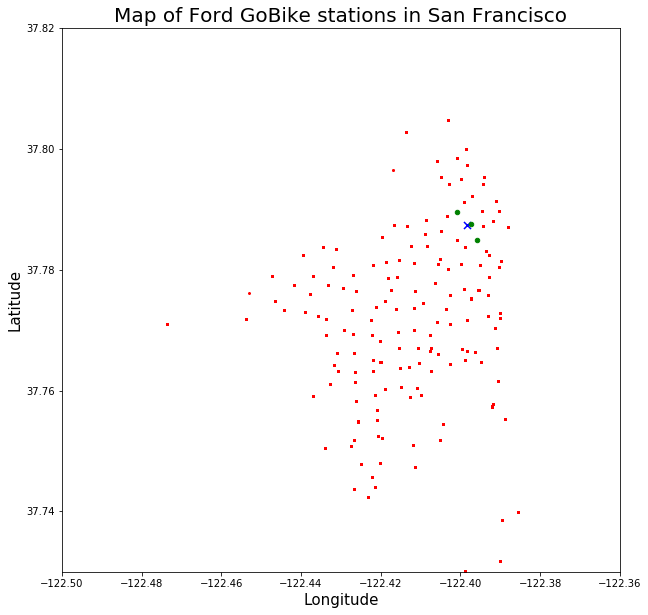

In [16]:
plt_neighbors(city, neighbors, id_coord2)

In [17]:
def plt_stn():
    row_sze = len(neighbors)
    col_sze = len(next(iter(neighbors.values())))
    rnge = row_sze*col_sze
    fig = plt.figure(figsize=(10,10))
    graph = 1
    for k, v in neighbors.items():
        num = 1
        for s_id in v:
            plt.subplot(rnge,1,graph)
            plt.subplots_adjust(top=15, bottom =8)
            plt.xlabel("Day", size="15")
            plt.ylabel("Daily Trip Count", size ="15")
            plt.title("This is station {}, and it is neighbor #{} for station {}".format(s_id, num, k), size="20")
            ts = trips_per_day(sub, s_id)
            plt.plot(ts[:,0],ts[:,1])
            num+=1
            graph+=1
            break
            

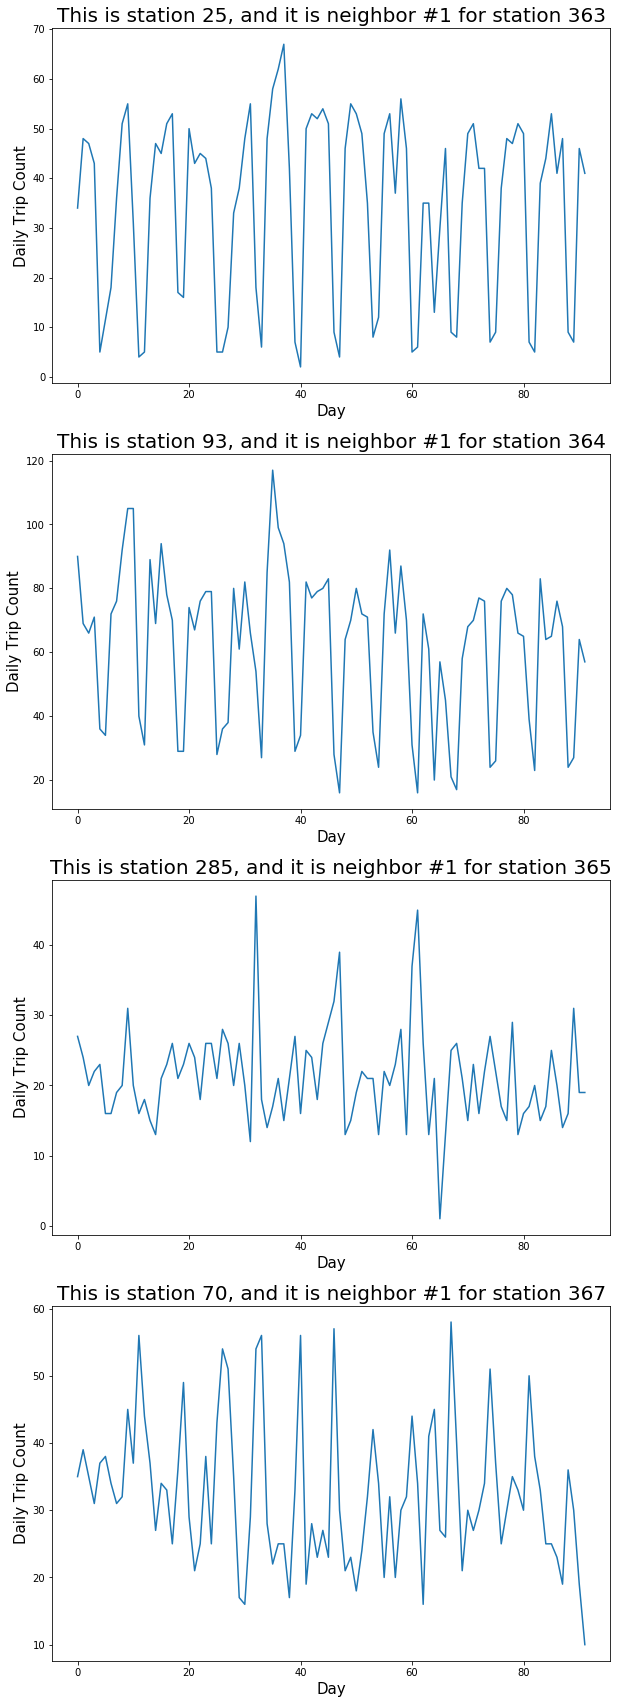

In [18]:
plt_stn()

## Testing Stations/Debugging

In [19]:
neighbors


{363: [25, 21, 37], 364: [93, 92, 81], 365: [285, 55, 31], 367: [70, 52, 71]}

In [175]:
test_station=37

In [176]:
#array of trips per each day for test_station
ts = trips_per_day(sub, test_station)
ts

array([[ 0, 55],
       [ 1, 53],
       [ 2, 52],
       [ 3, 50],
       [ 4,  6],
       [ 5, 12],
       [ 6, 68],
       [ 7, 55],
       [ 8, 55],
       [ 9, 81],
       [10, 43],
       [11,  9],
       [12,  6],
       [13, 47],
       [14, 44],
       [15, 55],
       [16, 49],
       [17, 44],
       [18,  3],
       [19,  9],
       [20, 52],
       [21, 46],
       [22, 49],
       [23, 49],
       [24, 45],
       [25,  2],
       [26,  3],
       [27, 10],
       [28, 49],
       [29, 47],
       [30, 53],
       [31, 43],
       [32, 29],
       [33, 17],
       [34, 60],
       [35, 57],
       [36, 51],
       [37, 60],
       [38, 41],
       [39,  5],
       [40,  7],
       [41, 31],
       [42, 68],
       [43, 57],
       [44, 63],
       [45, 59],
       [46,  7],
       [47,  5],
       [48, 52],
       [49, 61],
       [50, 54],
       [51, 63],
       [52, 53],
       [53,  6],
       [54,  8],
       [55, 60],
       [56, 74],
       [57, 51],
       [58, 68

In [177]:
tseries = pd.Series(ts[:,1])

In [178]:
tseries.values

array([55, 53, 52, 50,  6, 12, 68, 55, 55, 81, 43,  9,  6, 47, 44, 55, 49,
       44,  3,  9, 52, 46, 49, 49, 45,  2,  3, 10, 49, 47, 53, 43, 29, 17,
       60, 57, 51, 60, 41,  5,  7, 31, 68, 57, 63, 59,  7,  5, 52, 61, 54,
       63, 53,  6,  8, 60, 74, 51, 68, 45,  5,  7, 41, 57,  4, 42, 46, 10,
        7, 41, 51, 53, 48, 39, 15,  9, 55, 41, 54, 64, 40,  8,  6, 48, 67,
       53, 50, 45, 13,  8, 41, 52])

In [179]:
#test to see if the series is stationary
test = sm.tsa.stattools.adfuller(tseries)
print("ADF p-value: {0:2.2f}".format(test[1]))

ADF p-value: 0.18


In [180]:
tseries_diffed = tseries.diff()[1:]

In [181]:
sm.tsa.stattools.adfuller(tseries_diffed)[1]

1.1248282717197434e-05

In [182]:
sm.tsa.stattools.adfuller(tseries_diffed)[1]<0.05

True

In [183]:
def stationary_convert(series, pvalue=0.05):
    test = sm.tsa.stattools.adfuller(series)
    if test[1] > pvalue:
        tseries_diffed = tseries.diff()[1:]
        return tseries_diffed
    return series

In [184]:
tseries_diff = stationary_convert(tseries)
sm.tsa.stattools.adfuller(tseries_diff)[1]<0.05

True

In [185]:
trip_vals = tseries.values
trip_vals

array([55, 53, 52, 50,  6, 12, 68, 55, 55, 81, 43,  9,  6, 47, 44, 55, 49,
       44,  3,  9, 52, 46, 49, 49, 45,  2,  3, 10, 49, 47, 53, 43, 29, 17,
       60, 57, 51, 60, 41,  5,  7, 31, 68, 57, 63, 59,  7,  5, 52, 61, 54,
       63, 53,  6,  8, 60, 74, 51, 68, 45,  5,  7, 41, 57,  4, 42, 46, 10,
        7, 41, 51, 53, 48, 39, 15,  9, 55, 41, 54, 64, 40,  8,  6, 48, 67,
       53, 50, 45, 13,  8, 41, 52])

In [186]:
trip_model = ARIMA(trip_vals, order=(3, 1, 0)).fit()

In [187]:
predictions = trip_model.predict(75, 85, typ='levels')
predictions

array([19.14009395, 19.84056536, 58.33469756, 20.86576277, 57.32239763,
       58.67689427, 34.78883284, 18.00337279, 21.14963221, 50.03170367,
       48.17414765])

In [188]:
test = np.append(trip_vals, predictions)

In [189]:
test1 = pd.Series(test)

In [464]:
np.set_printoptions(suppress=True)

In [658]:
np.array(sub.days[sub.end_station_id == 37].value_counts())

array([81, 74, 68, 68, 68, 67, 64, 63, 63, 61, 60, 60, 60, 59, 57, 57, 57,
       55, 55, 55, 55, 55, 54, 54, 53, 53, 53, 53, 53, 52, 52, 52, 52, 51,
       51, 51, 50, 50, 49, 49, 49, 49, 48, 48, 47, 47, 46, 46, 45, 45, 45,
       44, 44, 43, 43, 42, 41, 41, 41, 41, 41, 40, 39, 31, 29, 17, 15, 13,
       12, 10, 10,  9,  9,  9,  8,  8,  8,  7,  7,  7,  7,  6,  6,  6,  6,
        5,  5,  5,  4,  3,  3,  2])

## Detrend for Seasonality

In [614]:
original_df = sub[['end_time','days']][sub.end_station_id == 37]

In [615]:
#change end_time to datetime
original_df['end_time']= pd.to_datetime(original_df.end_time)

In [616]:
#group trips by date and count 
#end time becomes index
grouped = original_df.groupby(original_df.end_time.dt.date).count()

In [617]:
#change index to datetime
grouped.index = pd.to_datetime(grouped.index)

In [652]:
#create our series
series = grouped['days']
series

end_time
2018-05-01    55
2018-05-02    53
2018-05-03    52
2018-05-04    50
2018-05-05     6
2018-05-06    12
2018-05-07    68
2018-05-08    55
2018-05-09    55
2018-05-10    81
2018-05-11    43
2018-05-12     9
2018-05-13     6
2018-05-14    47
2018-05-15    44
2018-05-16    55
2018-05-17    49
2018-05-18    44
2018-05-19     3
2018-05-20     9
2018-05-21    52
2018-05-22    46
2018-05-23    49
2018-05-24    49
2018-05-25    45
2018-05-26     2
2018-05-27     3
2018-05-28    10
2018-05-29    49
2018-05-30    47
              ..
2018-07-02    41
2018-07-03    57
2018-07-04     4
2018-07-05    42
2018-07-06    46
2018-07-07    10
2018-07-08     7
2018-07-09    41
2018-07-10    51
2018-07-11    53
2018-07-12    48
2018-07-13    39
2018-07-14    15
2018-07-15     9
2018-07-16    55
2018-07-17    41
2018-07-18    54
2018-07-19    64
2018-07-20    40
2018-07-21     8
2018-07-22     6
2018-07-23    48
2018-07-24    67
2018-07-25    53
2018-07-26    50
2018-07-27    45
2018-07-28    13
2018-

In [653]:
#get dummie variables
day = series.index.dayofweek
dummies = pd.get_dummies(day).iloc[:, :6]

In [654]:
X = sm.add_constant(dummies.values)

In [655]:
seasonal_model = sm.OLS(series.values, X).fit()

In [656]:
seasonal_trend = seasonal_model.predict(X)
seasonal_trend

array([55.5       , 48.92307692, 57.07692308, 45.61538462,  9.07692308,
        8.        , 46.61538462, 55.5       , 48.92307692, 57.07692308,
       45.61538462,  9.07692308,  8.        , 46.61538462, 55.5       ,
       48.92307692, 57.07692308, 45.61538462,  9.07692308,  8.        ,
       46.61538462, 55.5       , 48.92307692, 57.07692308, 45.61538462,
        9.07692308,  8.        , 46.61538462, 55.5       , 48.92307692,
       57.07692308, 45.61538462,  9.07692308,  8.        , 46.61538462,
       55.5       , 48.92307692, 57.07692308, 45.61538462,  9.07692308,
        8.        , 46.61538462, 55.5       , 48.92307692, 57.07692308,
       45.61538462,  9.07692308,  8.        , 46.61538462, 55.5       ,
       48.92307692, 57.07692308, 45.61538462,  9.07692308,  8.        ,
       46.61538462, 55.5       , 48.92307692, 57.07692308, 45.61538462,
        9.07692308,  8.        , 46.61538462, 55.5       , 48.92307692,
       57.07692308, 45.61538462,  9.07692308,  8.        , 46.61

In [657]:
np.array(series).T

array([55, 53, 52, 50,  6, 12, 68, 55, 55, 81, 43,  9,  6, 47, 44, 55, 49,
       44,  3,  9, 52, 46, 49, 49, 45,  2,  3, 10, 49, 47, 53, 43, 29, 17,
       60, 57, 51, 60, 41,  5,  7, 31, 68, 57, 63, 59,  7,  5, 52, 61, 54,
       63, 53,  6,  8, 60, 74, 51, 68, 45,  5,  7, 41, 57,  4, 42, 46, 10,
        7, 41, 51, 53, 48, 39, 15,  9, 55, 41, 54, 64, 40,  8,  6, 48, 67,
       53, 50, 45, 13,  8, 41, 52])

In [624]:
detrended_series = np.array(series).T - seasonal_trend
detrended_series

array([ -0.5       ,   4.07692308,  -5.07692308,   4.38461538,
        -3.07692308,   4.        ,  21.38461538,  -0.5       ,
         6.07692308,  23.92307692,  -2.61538462,  -0.07692308,
        -2.        ,   0.38461538, -11.5       ,   6.07692308,
        -8.07692308,  -1.61538462,  -6.07692308,   1.        ,
         5.38461538,  -9.5       ,   0.07692308,  -8.07692308,
        -0.61538462,  -7.07692308,  -5.        , -36.61538462,
        -6.5       ,  -1.92307692,  -4.07692308,  -2.61538462,
        19.92307692,   9.        ,  13.38461538,   1.5       ,
         2.07692308,   2.92307692,  -4.61538462,  -4.07692308,
        -1.        , -15.61538462,  12.5       ,   8.07692308,
         5.92307692,  13.38461538,  -2.07692308,  -3.        ,
         5.38461538,   5.5       ,   5.07692308,   5.92307692,
         7.38461538,  -3.07692308,   0.        ,  13.38461538,
        18.5       ,   2.07692308,  10.92307692,  -0.61538462,
        -4.07692308,  -1.        ,  -5.61538462,   1.5 

In [625]:
np.array(pd.Series(detrended_series).reset_index())

array([[  0.        ,  -0.5       ],
       [  1.        ,   4.07692308],
       [  2.        ,  -5.07692308],
       [  3.        ,   4.38461538],
       [  4.        ,  -3.07692308],
       [  5.        ,   4.        ],
       [  6.        ,  21.38461538],
       [  7.        ,  -0.5       ],
       [  8.        ,   6.07692308],
       [  9.        ,  23.92307692],
       [ 10.        ,  -2.61538462],
       [ 11.        ,  -0.07692308],
       [ 12.        ,  -2.        ],
       [ 13.        ,   0.38461538],
       [ 14.        , -11.5       ],
       [ 15.        ,   6.07692308],
       [ 16.        ,  -8.07692308],
       [ 17.        ,  -1.61538462],
       [ 18.        ,  -6.07692308],
       [ 19.        ,   1.        ],
       [ 20.        ,   5.38461538],
       [ 21.        ,  -9.5       ],
       [ 22.        ,   0.07692308],
       [ 23.        ,  -8.07692308],
       [ 24.        ,  -0.61538462],
       [ 25.        ,  -7.07692308],
       [ 26.        ,  -5.        ],
 

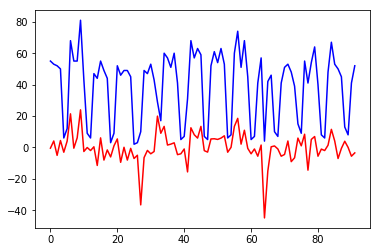

In [626]:
plt.plot(detrended_series, 'r', np.array(series),'b')


In [612]:
detrended_series.reshape(-1,1)

array([[ -0.5       ],
       [  4.07692308],
       [ -5.07692308],
       [  4.38461538],
       [ -3.07692308],
       [  4.        ],
       [ 21.38461538],
       [ -0.5       ],
       [  6.07692308],
       [ 23.92307692],
       [ -2.61538462],
       [ -0.07692308],
       [ -2.        ],
       [  0.38461538],
       [-11.5       ],
       [  6.07692308],
       [ -8.07692308],
       [ -1.61538462],
       [ -6.07692308],
       [  1.        ],
       [  5.38461538],
       [ -9.5       ],
       [  0.07692308],
       [ -8.07692308],
       [ -0.61538462],
       [ -7.07692308],
       [ -5.        ],
       [-36.61538462],
       [ -6.5       ],
       [ -1.92307692],
       [ -4.07692308],
       [ -2.61538462],
       [ 19.92307692],
       [  9.        ],
       [ 13.38461538],
       [  1.5       ],
       [  2.07692308],
       [  2.92307692],
       [ -4.61538462],
       [ -4.07692308],
       [ -1.        ],
       [-15.61538462],
       [ 12.5       ],
       [  8

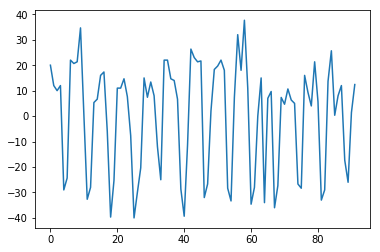

In [220]:
def trip_per_day(df, station_id):
    '''
    number of trips per day, given a station id
    INPUT: df and station id
    OUTPUT: sorted array of trip counts by date
    '''
    tseries = df[['end_time','days']][df.end_station_id == station_id]
    tseries = tseries.set_index('end_time')
    day = tseries.index.day
    dummies = pd.get_dummies(day).iloc[:, :29]
    X = sm.add_constant(dummies.values)
    seasonal_model = sm.OLS(tseries.values, X).fit()
    seasonal_trend = seasonal_model.predict(X)
    
    tseries = sub[['day','days']][sub.end_station_id == 37]
    tseries = tseries.set_index("day")
    tseries = tseries[np.argsort(tseries[:,1])]

    
    
    return tseries


In [221]:
trips_per_day(sub, test_station)

In [234]:
de.index

Int64Index([31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
            ...
             2,  2,  2,  1,  1,  1,  1,  1,  1,  1],
           dtype='int64', name='day', length=3576)

In [215]:
import statsmodels.api as sm
def create_monthly_dummies(series):
    month = series.index.month
    # Only take 11 of the 12 dummies to avoid strict collinearity.
    return pd.get_dummies(month).iloc[:, :11]
def fit_seasonal_trend(series):
    dummies = create_monthly_dummies(series)
    X = sm.add_constant(dummies.values)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)


In [ ]:
tseries_seasonal_trend = fit_seasonal_trend(tseries)
tseries_seasonal_detrended = tseries - tseries_seasonal_trend

# Starting Model

In [191]:
def ARIMA_pred(arr, p=1, d=1, q=1):
    
    tseries = pd.Series(arr[:,1])
#     tseries = stationary_convert(tseries)
    tscv = TimeSeriesSplit(n_splits=3)
    fig = plt.figure(figsize=(10,10))
    index = 1
    
    actual = []
    mean_rmse= np.array([])
    for train_index, test_index in tscv.split(tseries):
        train = tseries[train_index]
        test = tseries[test_index]

        train_vals = train.values
#         trip_model = ARIMA(train_vals, order=(p, d, q)).fit()
        try:
            trip_model = ARIMA(train_vals, order=(p, d, q)).fit()
        except:
            print("there was an exception with parameters {},{},{}".format(p,d,q))
        train_sze = len(train)
        predictions = trip_model.predict(train_sze, train_sze+len(test)-1, typ='levels')
        
        #calculate mean squared error
        mse = mean_squared_error(predictions, np.array(test))
        rmse = mse.mean()
        mean_rmse = np.append(mean_rmse, rmse)
        
        #combine train with predictions
        combined = np.append(train_vals, predictions)
        combined = pd.Series(combined)



    plt.xlabel('Days', size="15")
    plt.ylabel('Trip Counts',size ="15")
    plt.title('Testing with ARIMA model', size="20")
    plt.plot(combined.index[:train_sze], combined[:train_sze], 'g', label = "train")
    plt.plot(combined.index[train_sze:], combined[train_sze:], 'r', label =  "prediction")
    plt.plot(tseries.index[train_sze:], tseries[train_sze:], 'b', label = "actual")
    plt.legend(loc='upper left',prop={'size': 20})

    avg_rmse = mean_rmse.mean()
    return avg_rmse

In [192]:
#test to see if the series is stationary
test = sm.tsa.stattools.adfuller(ts[:,1])
print("ADF p-value: {0:2.2f}".format(test[1]))

ADF p-value: 0.18


In [193]:
def best_ARIMA_param(arr):
    max_param = 3
    score = np.array([0,0,0,0])
    exceptions = 0
    d=1
    q=0
    for p in range(1,max_param+1):
        # for d in range(1,max_param+1):
        #     for q in range(1,max_param+1):
        try:
            rmse = ARIMA_pred(arr, p, d, q)
            score_data = np.array([p,d,q,rmse])
            score = np.vstack((score, score_data))
        except: 
            # print("The hyper parameters {}, {}, and {} did not work.".format(p, d, q))
            exceptions +=1
    print ("There were a total of {} exceptions.".format(exceptions/max_param**3))
    return score[1:]

There were a total of 0.0 exceptions.


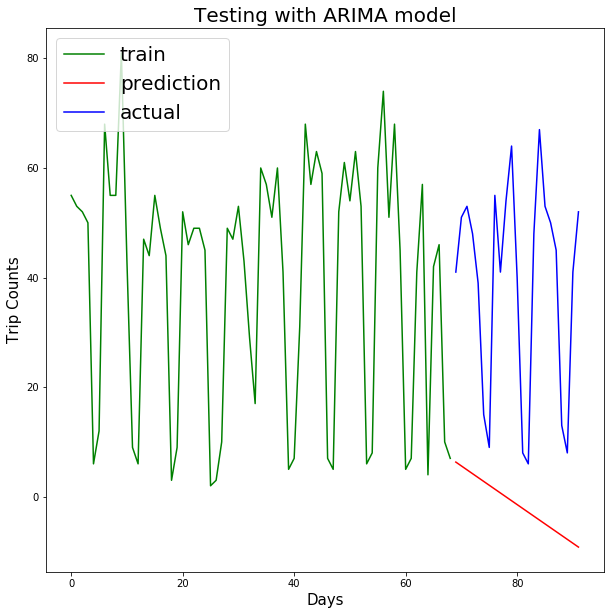

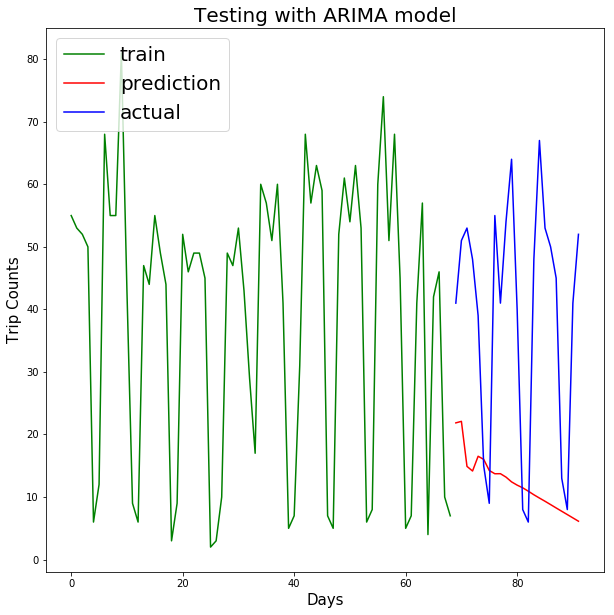

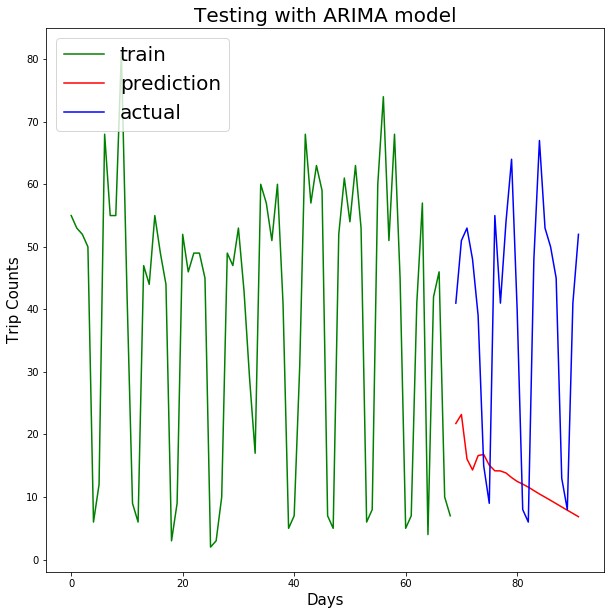

In [194]:
score = best_ARIMA_param(ts)

In [195]:
score

array([[1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.23914628e+03],
       [2.00000000e+00, 1.00000000e+00, 0.00000000e+00, 9.27112857e+02],
       [3.00000000e+00, 1.00000000e+00, 0.00000000e+00, 9.39853990e+02]])

In [196]:
np.sort(score[:,3]).reshape(-1,1)

array([[ 927.11285704],
       [ 939.85399029],
       [1239.14627586]])

In [197]:
np.sort(score[:,3]).reshape(-1,1)[0]

array([927.11285704])

In [198]:
score[:,3] ==np.sort(score[:,3]).reshape(-1,1)[0]

array([False,  True, False])

In [199]:
score[score[:,3] ==np.sort(score[:,3]).reshape(-1,1)[0]]

array([[  2.        ,   1.        ,   0.        , 927.11285704]])

In [200]:
score

array([[1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.23914628e+03],
       [2.00000000e+00, 1.00000000e+00, 0.00000000e+00, 9.27112857e+02],
       [3.00000000e+00, 1.00000000e+00, 0.00000000e+00, 9.39853990e+02]])

In [201]:
def best_params(score):
    best_params = score[score[:,3] ==np.sort(score[:,3]).reshape(-1,1)[0]]
    return best_params

In [202]:
b_params = best_params(score)

In [203]:
b_params

array([[  2.        ,   1.        ,   0.        , 927.11285704]])

In [204]:
ts[:,1].mean()

38.869565217391305

In [205]:
def forecast_nxt_30d(ts, b_params, months=3):
    tseries = pd.Series(ts[:,1])
    p = int(b_params[0][0])
    d = int(b_params[0][1])
    q = int(b_params[0][2])
    
    current_vals = tseries.values
    model = ARIMA(current_vals, order=(p, d, q)).fit()

    train_sze = len(current_vals)
#     predictions = trip_model.predict(train_sze, train_sze+30, typ='levels')
    predictions = model.predict((30*months), (30*months)+30, typ='levels')

    #combine to plot on same graph
    combined = np.append(current_vals, predictions)
    combined = pd.Series(combined)
#     plt.xlabel('Days')
#     plt.ylabel('Trip Counts')
#     plt.title("This is the forecasted trips per day for neighboring station {}.".format(station_id))
    # plt.plot(combined.index[:train_sze], combined[:train_sze])
    # plt.plot(combined.index[train_sze:], combined[train_sze:])
    
    plt.figure(figsize = (10,5))
    plt.ylabel("Trip Count", size ="10")
    plt.xlabel("Days")
    plt.title("Forecasted Trip Count for the next 30 days", size="15")
    plt.plot(combined.index[:train_sze], combined[:train_sze], 'g', label = "train")
    plt.plot(combined.index[train_sze:], combined[train_sze:], 'r', label =  "prediction")
    plt.plot(tseries.index[train_sze:], tseries[train_sze:], 'b', label = "actual")
    next_month_avg_pred = predictions.mean()
    plt.legend(loc='upper left')
    return next_month_avg_pred

In [206]:
tseries = pd.Series(ts[:,1])
current_vals= tseries.values
current_vals

array([55, 53, 52, 50,  6, 12, 68, 55, 55, 81, 43,  9,  6, 47, 44, 55, 49,
       44,  3,  9, 52, 46, 49, 49, 45,  2,  3, 10, 49, 47, 53, 43, 29, 17,
       60, 57, 51, 60, 41,  5,  7, 31, 68, 57, 63, 59,  7,  5, 52, 61, 54,
       63, 53,  6,  8, 60, 74, 51, 68, 45,  5,  7, 41, 57,  4, 42, 46, 10,
        7, 41, 51, 53, 48, 39, 15,  9, 55, 41, 54, 64, 40,  8,  6, 48, 67,
       53, 50, 45, 13,  8, 41, 52])

35.41940709983918

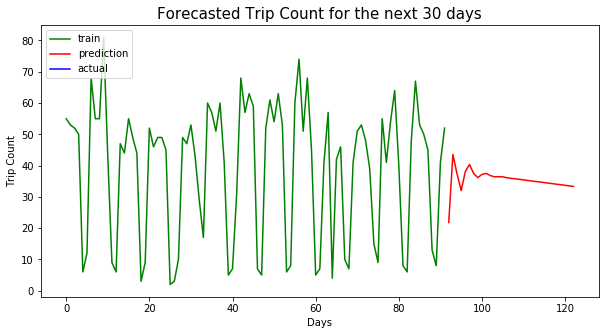

In [207]:
forecast_nxt_30d(ts, b_params)

In [208]:
tseries = pd.Series(ts[:,1])
current_vals = tseries.values
model = ARIMA(current_vals, order=(1, 1, 1)).fit()

In [209]:
test = tseries.index[:5].reindex(range(3,8))

In [144]:
ndf.head(2)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,member_gender,bike_share_for_all_trip,day_of_week,date,year,month,day,hour,malfunction,age
1863722,65900,2019-01-31 20:58:33.8860,2019-02-01 15:16:54.173,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915,134.0,Valencia St at 24th St,37.752428,...,Male,No,4,2019-02-01,2019,2,1,15,False,30.0
1863724,44680,2019-01-31 19:46:09.7190,2019-02-01 08:10:50.318,85.0,Church St at Duboce Ave,37.770083,-122.429156,53.0,Grove St at Divisadero,37.775946,...,Male,No,4,2019-02-01,2019,2,1,8,False,45.0


In [145]:
val_df = ndf[ndf.end_station_id == test_station]
count = val_df.day.value_counts()
actual_trips_per_day = np.array(count).mean()

In [146]:
actual_trips_per_day

27.071428571428573

In [147]:
neighbors

{344: [345, 116, 115],
 386: [134, 133, 141],
 51: [377, 380, 375],
 398: [371, 369, 370]}

## apply predictions to neighbor statoins

In [148]:
def station_trends(sub,cdf,neighbors):
    #stores the proposed location's stations id and its neighbors' overall average trip count per day
    trend = {}
    #get the orgin station and its neighbor
    for k, v in neighbors.items():
        
        avg_temp = []
        #access each neighbor for station k
        for s in v:
            try:
                print ("This is station {}, and the neighbor is {}".format(k,s))

                #time series data for station s
                ts = trips_per_day(sub,s)

                #scores for each ARIMA hyper parameter combination
                score = best_ARIMA_param(ts)

                #best hyper parameter for the model
                #based on smallest MSE
                b_params = best_params(score)

                #average prediction of trips per day for the next month
                avg_pred = forecast_nxt_30d(ts, b_params)
                avg_temp.append(avg_pred)
            except:
                print ("Combination did not work")
        neigh_avg = np.array(avg_temp)
        trend[k] = neigh_avg
    return trend

This is station 344, and the neighbor is 345
There were a total of 0.0 exceptions.
This is station 344, and the neighbor is 116
There were a total of 0.0 exceptions.
This is station 344, and the neighbor is 115
There were a total of 0.0 exceptions.
This is station 386, and the neighbor is 134
There were a total of 0.0 exceptions.
This is station 386, and the neighbor is 133
There were a total of 0.0 exceptions.
This is station 386, and the neighbor is 141
There were a total of 0.0 exceptions.
This is station 51, and the neighbor is 377


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


There were a total of 0.0 exceptions.
This is station 51, and the neighbor is 380


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

There were a total of 0.0 exceptions.
This is station 51, and the neighbor is 375


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

There were a total of 0.0 exceptions.
This is station 398, and the neighbor is 371


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

There were a total of 0.0 exceptions.
This is station 398, and the neighbor is 369


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

There were a total of 0.0 exceptions.
This is station 398, and the neighbor is 370


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

There were a total of 0.0 exceptions.


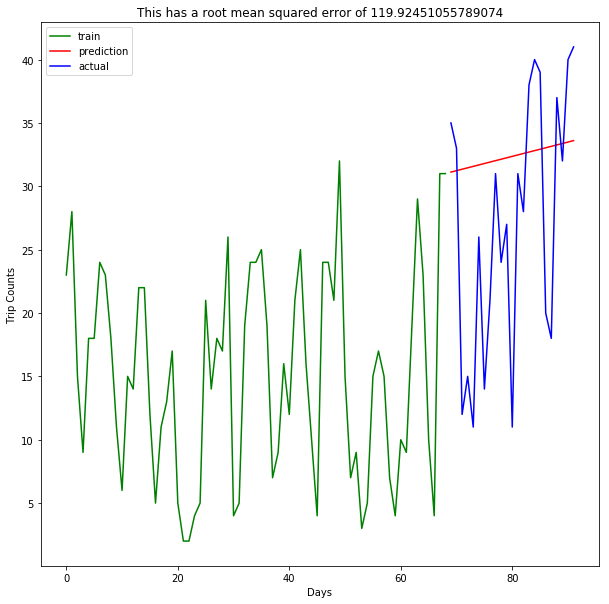

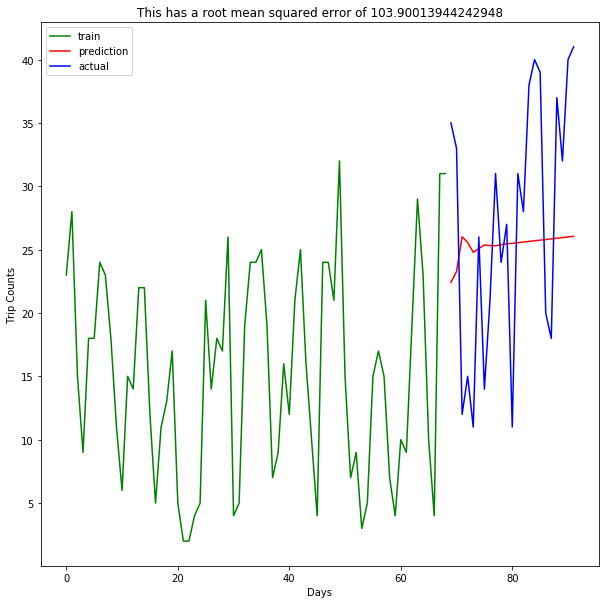

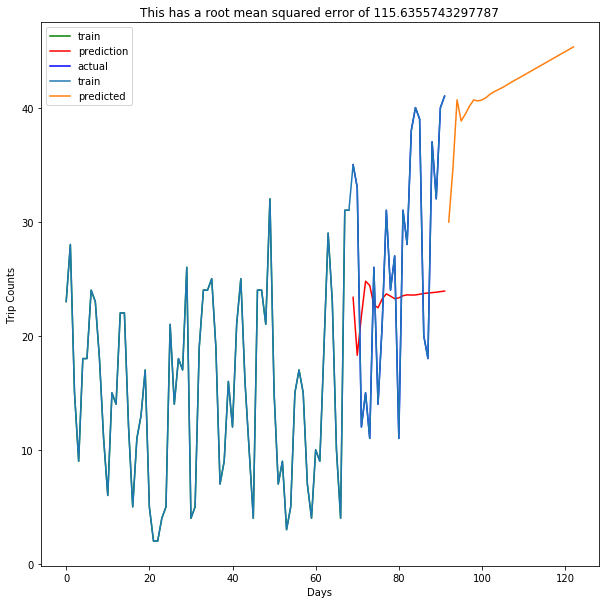

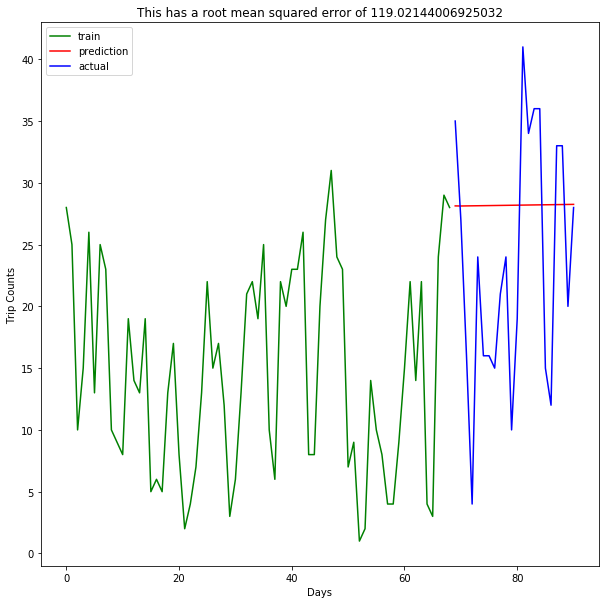

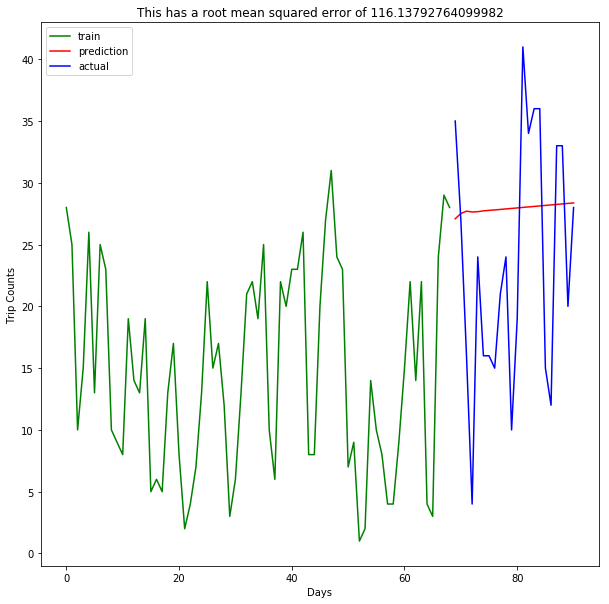

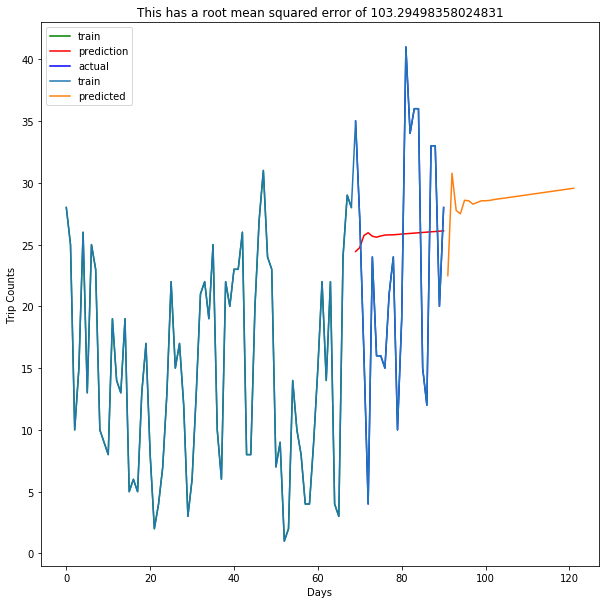

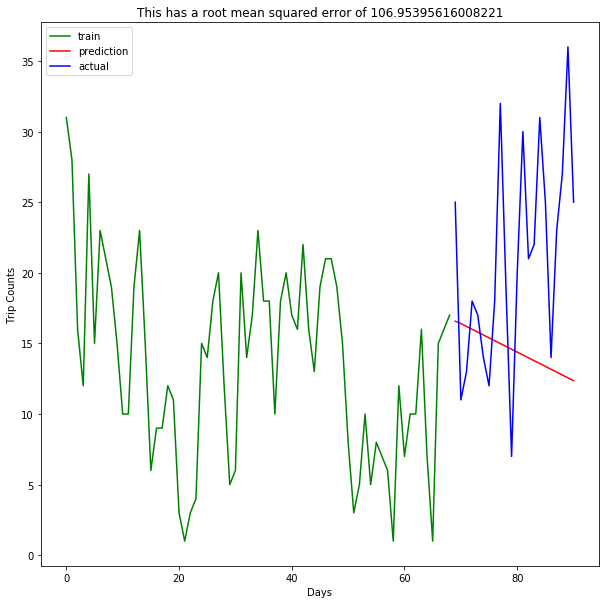

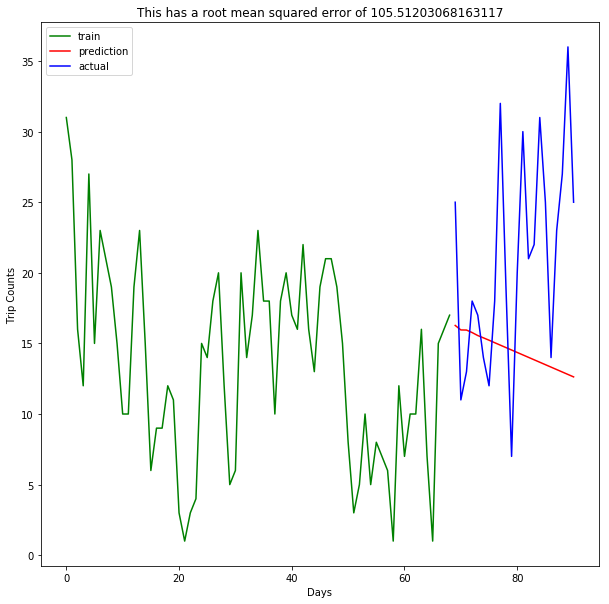

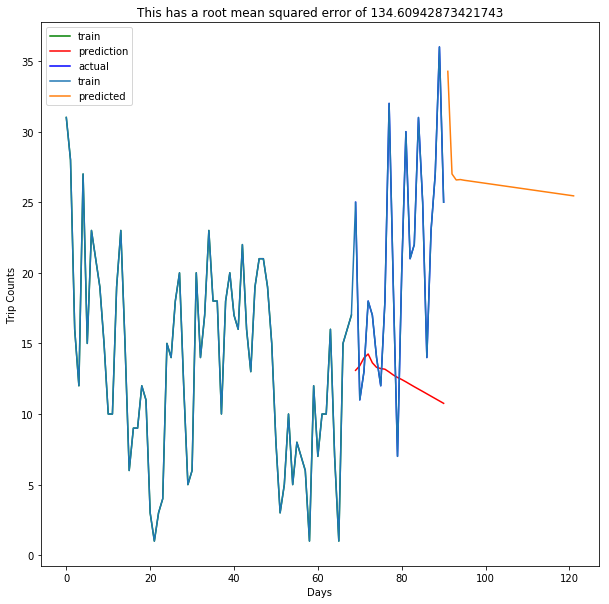

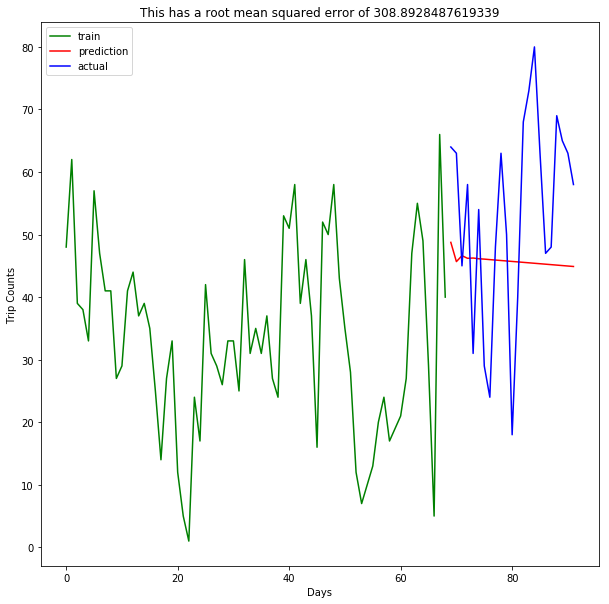

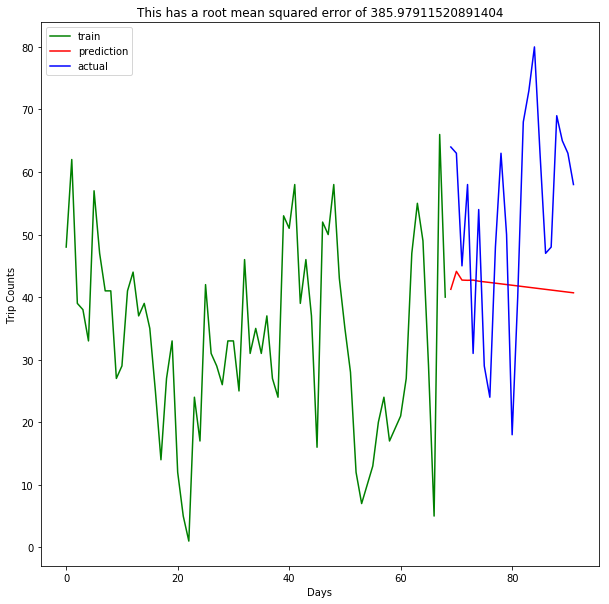

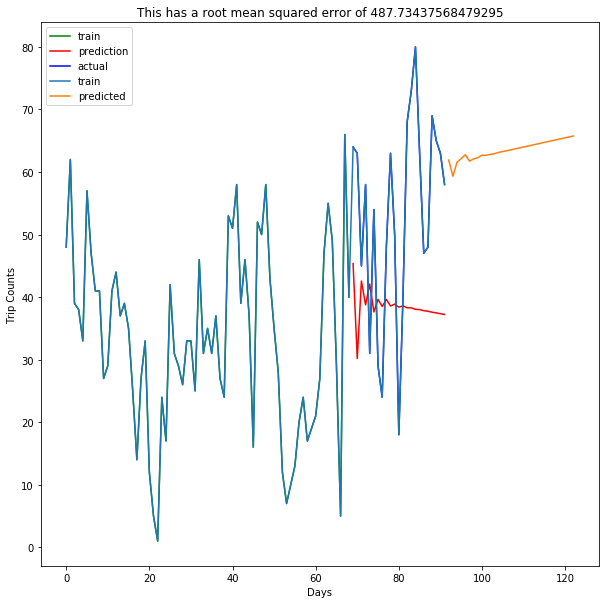

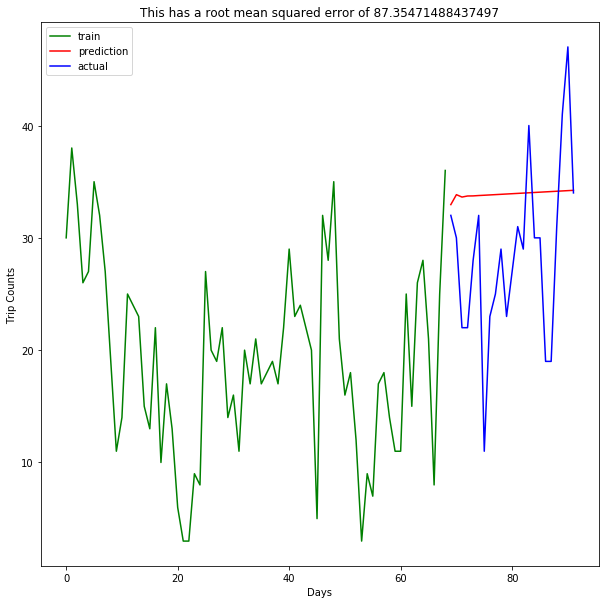

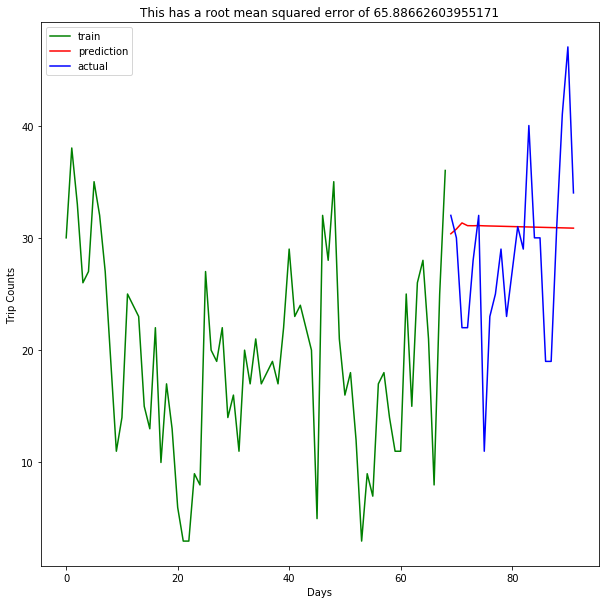

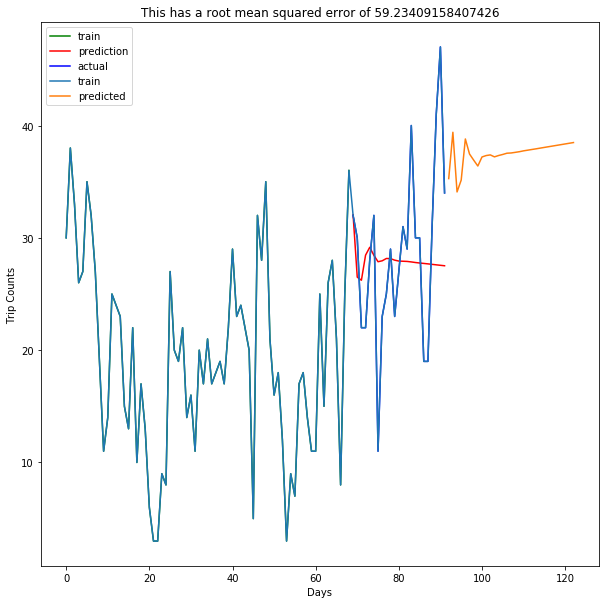

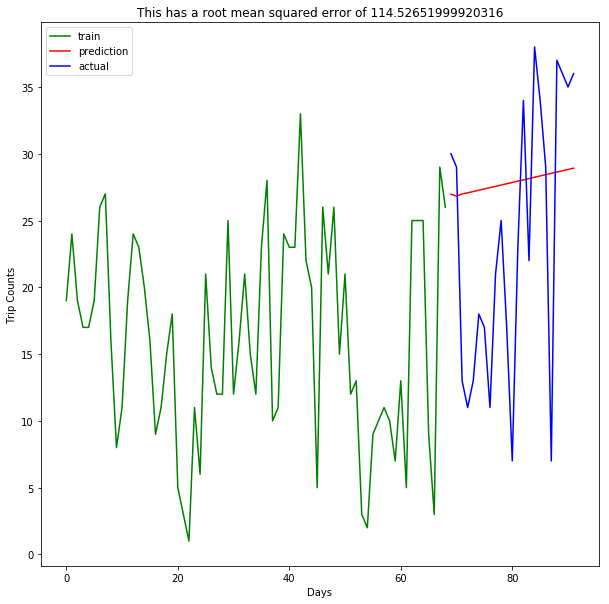

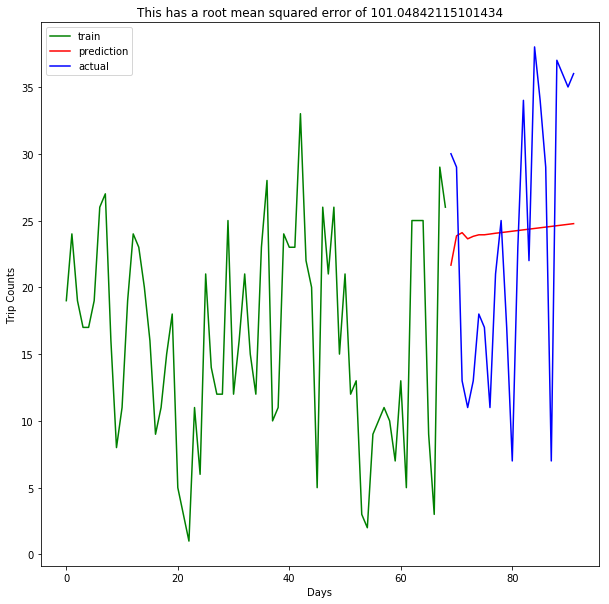

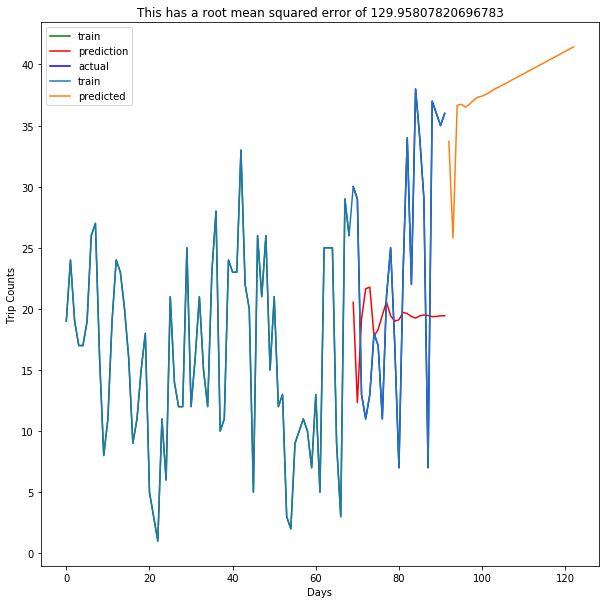

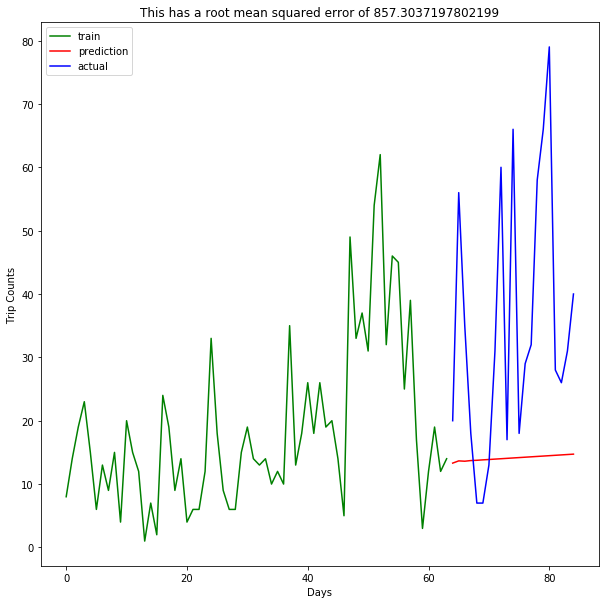

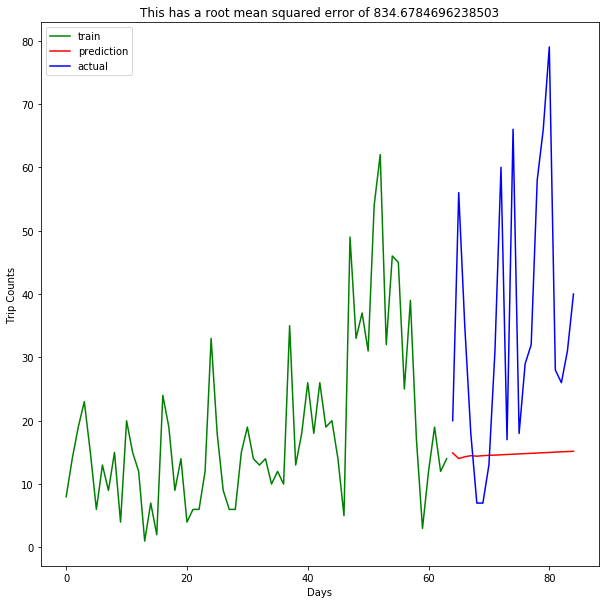

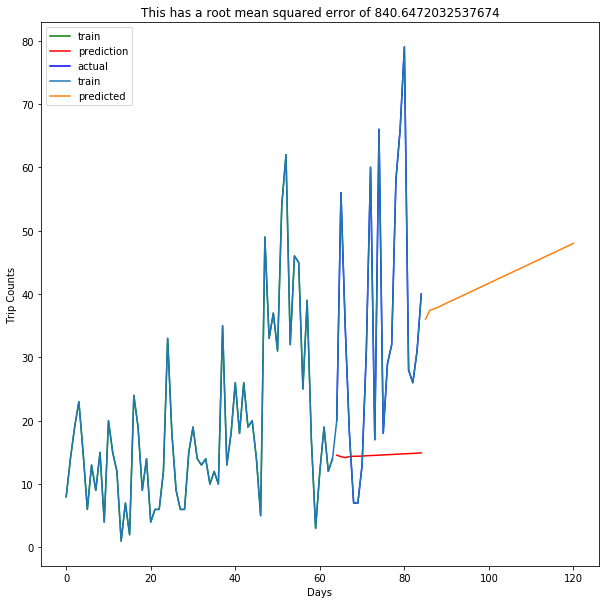

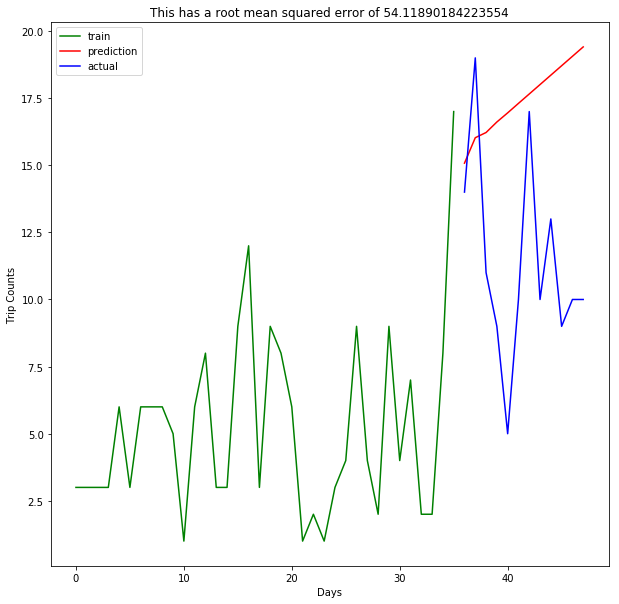

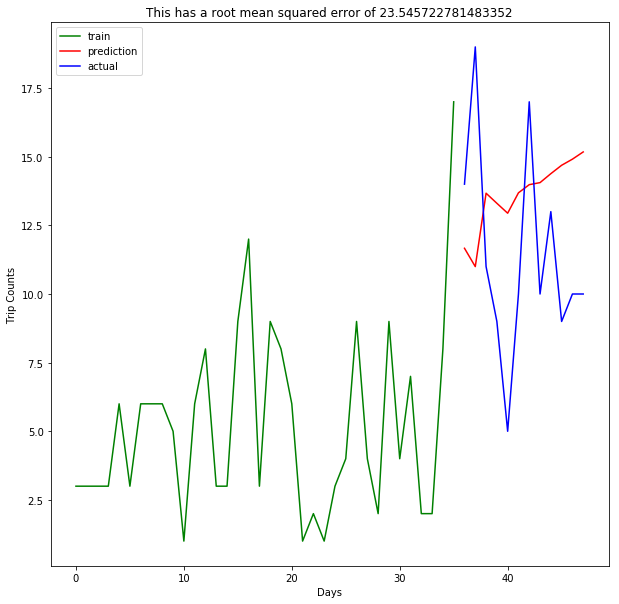

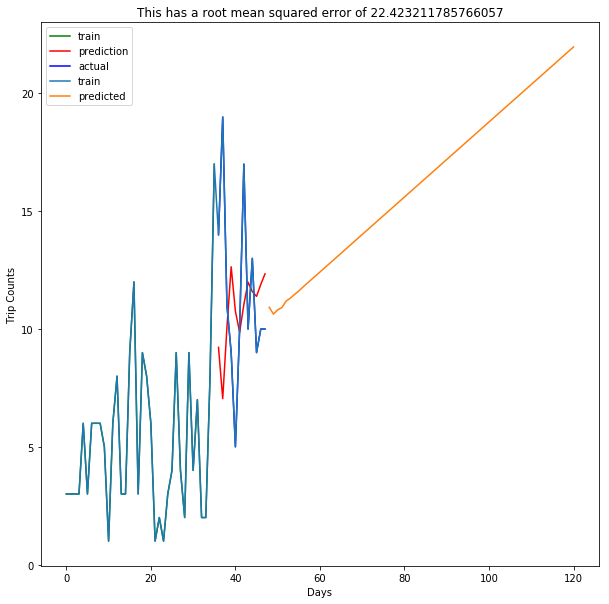

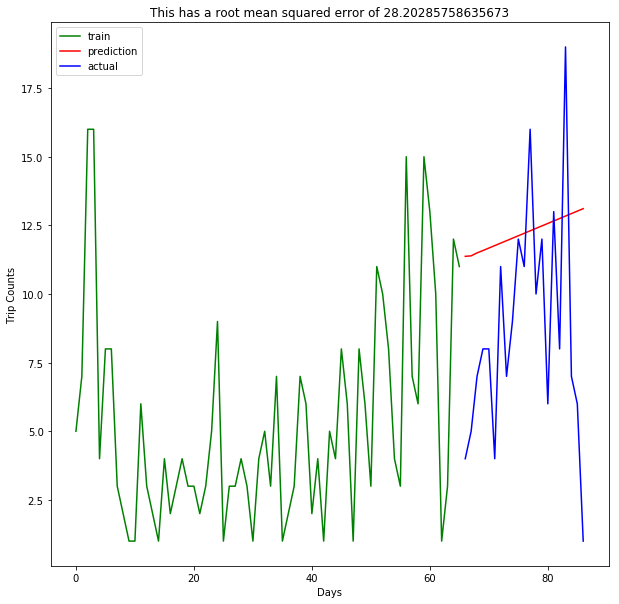

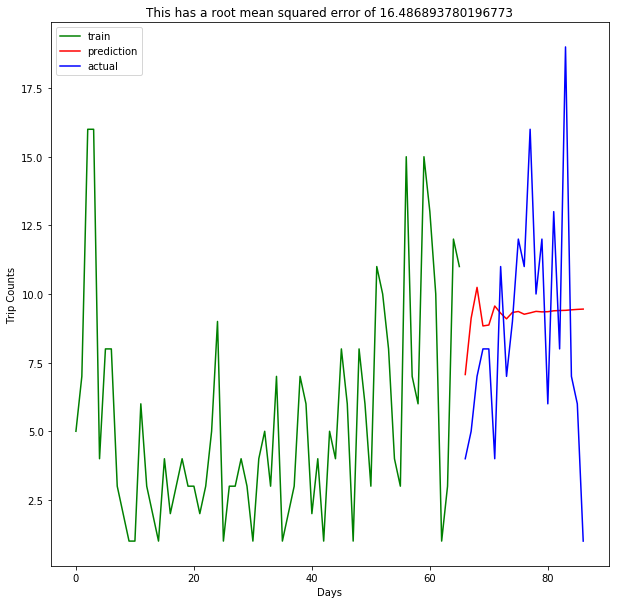

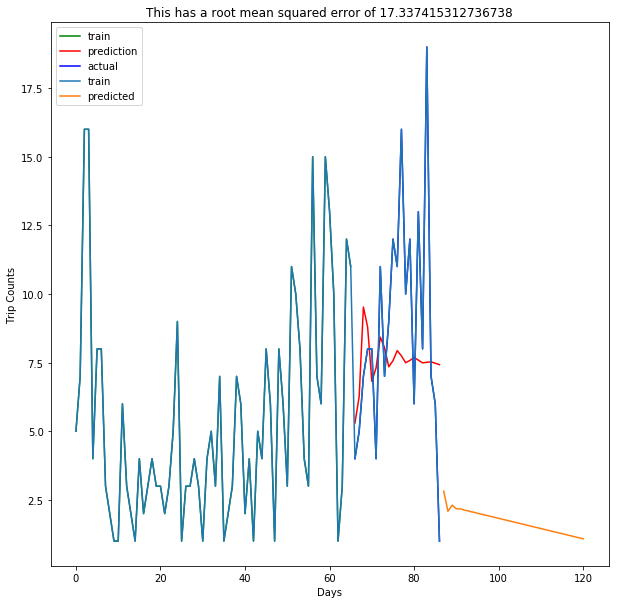

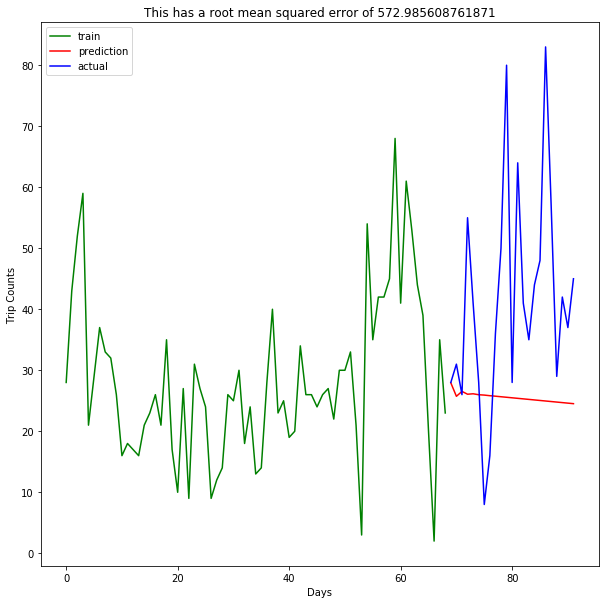

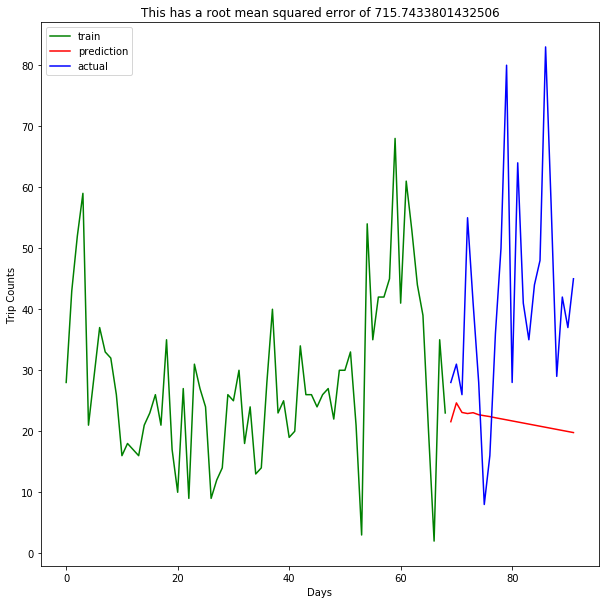

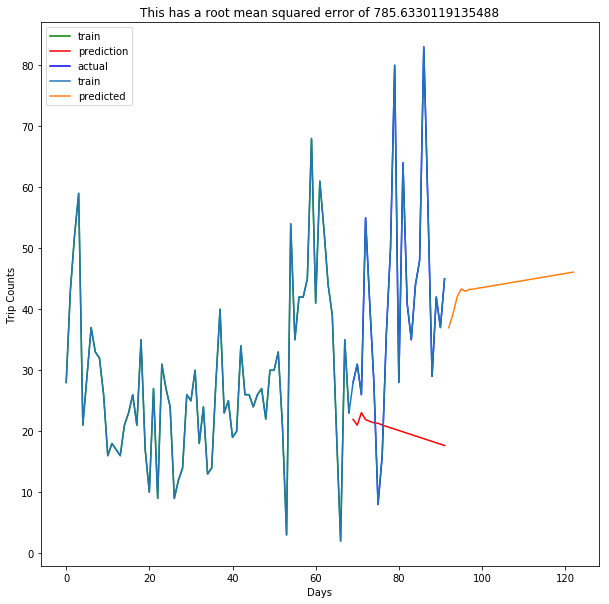

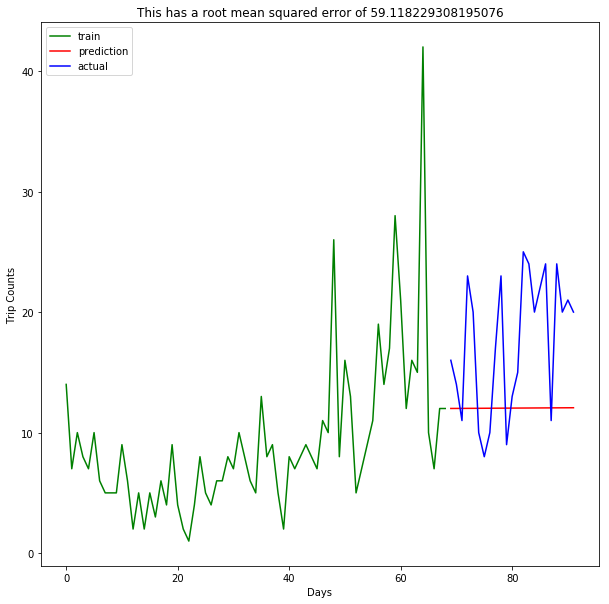

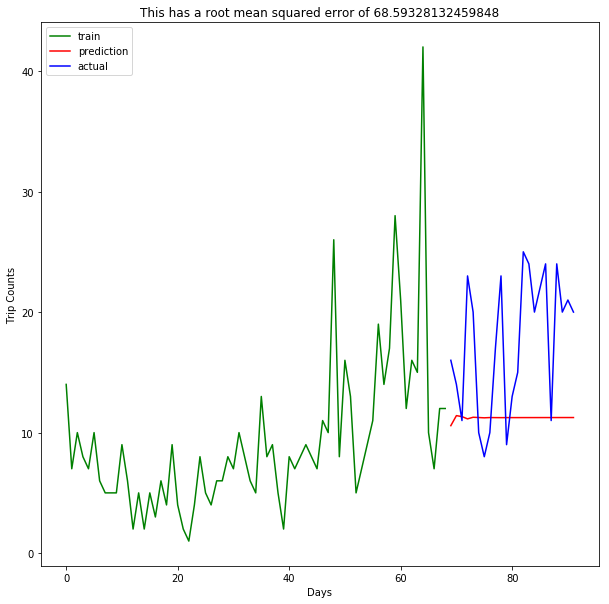

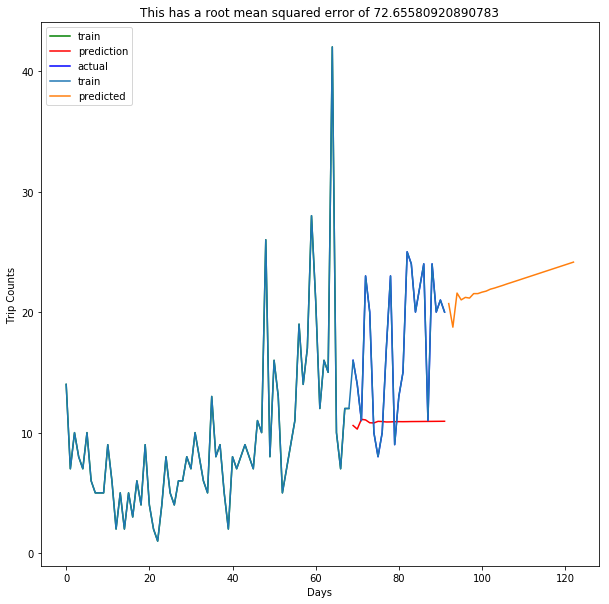

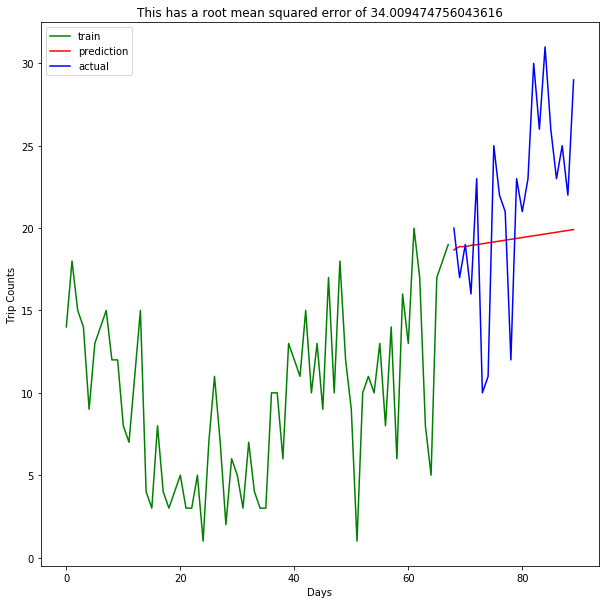

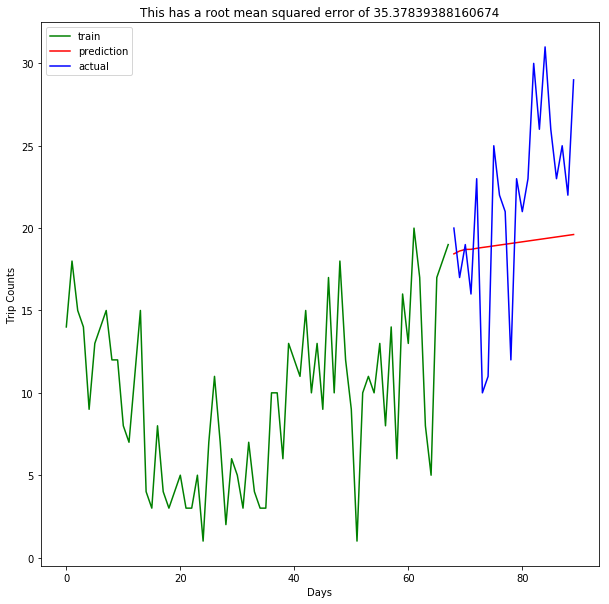

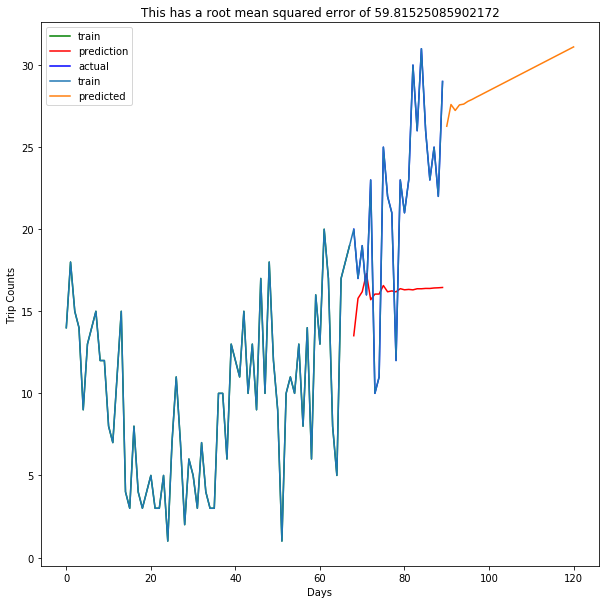

In [149]:
trend = station_trends(sub,cdf, neighbors)

In [150]:
trend

{344: array([41.76035801, 28.70995068, 26.33873962]),
 386: array([63.52884112, 37.52285344, 38.30410521]),
 51: array([42.46704986, 16.24697958,  1.70897827]),
 398: array([44.04198835, 22.39179392, 29.09163188])}

In [151]:
neighbors

{344: [345, 116, 115],
 386: [134, 133, 141],
 51: [377, 380, 375],
 398: [371, 369, 370]}

In [152]:
np.array(sub.days[sub.end_station_id == 345].value_counts()).mean()

18.108695652173914

In [153]:
def baseline(neighbors, sub):
    avg_count = {}
    for k, v in neighbors.items():
        avg_lst = []
        for s_id in v:
            avg = np.array(sub.days[sub.end_station_id == s_id].value_counts()).mean()
            avg_lst.append(avg)
        avg = np.round(np.array(avg_lst).mean(),decimals=3)
        avg_count[k] = avg
    return avg_count

In [154]:
baseline(neighbors,sub)

{344: 16.732, 386: 25.891, 51: 11.817, 398: 18.45}

In [173]:
neighbors

{344: [345, 116, 115],
 386: [134, 133, 141],
 51: [377, 380, 375],
 398: [371, 369, 370]}

In [529]:
def validate(sub, neighbors, trend, ndf):
    
    base = baseline(neighbors,sub)
    #validate the stations in the trend dictionary
    for k, v in trend.items():
        
        #mean of forecasted values
        neighbor_mean = v.mean()
        
        #using the following month's data to calculate actual trips per day
        count = ndf[ndf.end_station_id == k]["day"].value_counts()
        actual_trips_per_day = np.round(np.array(count).mean(), decimals = 3)

        
        print ("Validating for station {}".format(k))
        print ("The baseline estimate using the mean for neighboring station is {}".format(base.get(k)))
        print ("The average predicted trip count per day is {}.".format(neighbor_mean)) 
        print ("The actual trips per day for the following month is {}.".format(actual_trips_per_day))
        print ("----------------------------------------------------------------")


In [530]:
validate(city,sub, neighbors, trend, ndf)

AttributeError: 'function' object has no attribute 'items'

In [186]:
np.array(ndf[ndf.end_station_id == 386]['day'].value_counts()).mean()

22.0

In [377]:
data = sub['days'][sub.end_station_id == 25].value_counts().reset_index()
average = np.array(data.iloc[:,1]).mean()

zero = 0

In [389]:
data['diff'] = data.days - average

In [390]:
test_s = data.drop('days', axis=1)
diff_arr = np.array(test_s)

diff_arr

array([[ 37.        ,  32.57142857],
       [ 36.        ,  27.57142857],
       [ 35.        ,  23.57142857],
       [ 58.        ,  21.57142857],
       [  9.        ,  20.57142857],
       [ 31.        ,  20.57142857],
       [ 49.        ,  20.57142857],
       [ 44.        ,  19.57142857],
       [ 56.        ,  18.57142857],
       [ 50.        ,  18.57142857],
       [ 17.        ,  18.57142857],
       [ 85.        ,  18.57142857],
       [ 42.        ,  18.57142857],
       [ 43.        ,  17.57142857],
       [  8.        ,  16.57142857],
       [ 45.        ,  16.57142857],
       [ 79.        ,  16.57142857],
       [ 16.        ,  16.57142857],
       [ 71.        ,  16.57142857],
       [ 41.        ,  15.57142857],
       [ 20.        ,  15.57142857],
       [ 55.        ,  14.57142857],
       [ 51.        ,  14.57142857],
       [ 70.        ,  14.57142857],
       [ 80.        ,  14.57142857],
       [ 77.        ,  13.57142857],
       [ 34.        ,  13.57142857],
 

In [394]:
diff_arr[:,1][diff_arr[:,1]<0] = 0

In [396]:
diff_arr

array([[37.        , 32.57142857],
       [36.        , 27.57142857],
       [35.        , 23.57142857],
       [58.        , 21.57142857],
       [ 9.        , 20.57142857],
       [31.        , 20.57142857],
       [49.        , 20.57142857],
       [44.        , 19.57142857],
       [56.        , 18.57142857],
       [50.        , 18.57142857],
       [17.        , 18.57142857],
       [85.        , 18.57142857],
       [42.        , 18.57142857],
       [43.        , 17.57142857],
       [ 8.        , 16.57142857],
       [45.        , 16.57142857],
       [79.        , 16.57142857],
       [16.        , 16.57142857],
       [71.        , 16.57142857],
       [41.        , 15.57142857],
       [20.        , 15.57142857],
       [55.        , 14.57142857],
       [51.        , 14.57142857],
       [70.        , 14.57142857],
       [80.        , 14.57142857],
       [77.        , 13.57142857],
       [34.        , 13.57142857],
       [30.        , 13.57142857],
       [ 1.        ,

In [398]:
tseries = diff_arr[np.argsort(diff_arr[:,0])]

In [399]:
tseries

array([[ 0.        ,  0.        ],
       [ 1.        , 13.57142857],
       [ 2.        , 12.57142857],
       [ 3.        ,  8.57142857],
       [ 4.        ,  0.        ],
       [ 6.        ,  0.        ],
       [ 7.        ,  1.57142857],
       [ 8.        , 16.57142857],
       [ 9.        , 20.57142857],
       [10.        ,  0.        ],
       [11.        ,  0.        ],
       [12.        ,  0.        ],
       [13.        ,  1.57142857],
       [14.        , 12.57142857],
       [15.        , 10.57142857],
       [16.        , 16.57142857],
       [17.        , 18.57142857],
       [18.        ,  0.        ],
       [19.        ,  0.        ],
       [20.        , 15.57142857],
       [21.        ,  8.57142857],
       [22.        , 10.57142857],
       [23.        ,  9.57142857],
       [24.        ,  3.57142857],
       [25.        ,  0.        ],
       [26.        ,  0.        ],
       [27.        ,  0.        ],
       [28.        ,  0.        ],
       [29.        ,